### Importing the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
import io

### Importing the Data

In [2]:
dimAuction  = pd.read_csv(r'Data/Dim_auction.csv', sep=";") 
factLots1 = pd.read_excel(r'Data/fact_lots_1.xlsx', skiprows = 2)
factLots2 = pd.read_excel(r'Data/fact_lots_2.xlsx', skiprows = 2)
factBids = pd.read_csv(r'Data/Fact_bids1.csv', sep=";")
dimProjects = pd.read_csv(r'Data/Dim_projects.csv', sep=",")
dimLot = pd.read_csv(r'Data/DIM_LOT.csv', sep=";")
auctionCloseTimes = pd.read_csv(r'Data/AuctionCloseTimes.csv', sep=",")

C:\Users\muhka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\muhka\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


#### Step 1 - Remove the colums which are identified as not applicable by the project owner

In [3]:
# not applicable columns per dataset
na_dimProjects = ['project_auction_start','project_auction_end','project_auction_online']
na_dimAuction = ['is_active','open_for_bidding']
na_factBids = ['seller_id','channel_id']
na_fact12 = ['seller_id']

#correct the dimProjects dataset
for i in na_dimProjects:
    dimProjects.drop(i,inplace=True,axis=1)

# #correct the dimAuction dataset
for i in na_dimAuction:
    dimAuction.drop(i,inplace=True,axis=1)
    
# #correct the factBids dataset
for i in na_factBids:
    factBids.drop(i,inplace=True,axis=1)

#correct the factLots1 dataset
for i in na_fact12:
    factLots1.drop(i,inplace=True,axis=1)
    
#correct the factLots2 dataset
for i in na_fact12:
    factLots2.drop(i,inplace=True,axis=1)

#### Step 2 - Remove the rows which carry data about the business line '006 Automotive'

In [4]:
# only keep the rows for which the busines line is not automotive    
factBids = factBids.loc[factBids['efficy_business_line'] != '006.Automotive']
factLots1 = factLots1.loc[factLots1['efficy_business_line'] != '006.Automotive']
factLots2 = factLots2.loc[factLots2['efficy_business_line'] != '006.Automotive']
dimProjects = dimProjects.loc[dimProjects['project_businessline'] != '006.Automotive']

#### Step 3 - Change column type for 'bid_amount' to float64

In [5]:
def float_checker(x):
    try:
        return float(x.split()[0].replace(',', '.'))
    except:
        return x
               
factBids['bid_amount'] = factBids['bid_amount'].apply(float_checker)

#### Step 4 - Check for missing values

In [6]:
# clean dimAuction
dimAuction.drop(columns=['onlinedate','is_public'])

# clean dimLot
dimLot['valid_bid_count'] = dimLot['valid_bid_count'].fillna(0)
dimLot.drop(columns=['newprice','uitleverdatum','latest_creditreason','type'])                   

# merge factLot1 and factLoc2
factLots = factLots1.append(factLots2)
            
# clean dimProjects
dimProjects = dimProjects.dropna(how='all', subset=['project_businessline'])   

### Merging the Datasets

In [7]:
# Creating a dataframe for auction related variables
auction_related = pd.merge(dimProjects, dimAuction[dimAuction.columns.difference(["is_public"])], on ='auction_id', how ='outer')
auction_related["is_homedelivery"] = np.where(np.isnan(auction_related["is_homedelivery_x"]), auction_related["is_homedelivery_y"], auction_related["is_homedelivery_x"])
auction_related = auction_related.filter(["auction_id",'is_homedelivery', 'is_public', "is_automatic_credit", "sourcing_company"])
auction_related = auction_related.dropna()
auction_related = auction_related.reset_index(drop=True)
auction_related

,auction_id,is_homedelivery,is_public,is_automatic_credit,sourcing_company
0,37597,1.0,1.0,0.0,art
1,37598,1.0,1.0,0.0,art
2,40620,0.0,1.0,0.0,bva
3,43832,0.0,1.0,0.0,bva
4,43843,0.0,0.0,0.0,bva
...,...,...,...,...,...
896,46133,0.0,1.0,0.0,bva
897,46152,0.0,0.0,0.0,bva
898,46156,0.0,0.0,0.0,bva
899,46187,0.0,0.0,0.0,bva


In [8]:
# Creating a dataframe for lot related variables

# Adding lot related features into a new dataframe
# (auction_id, lot_id, auctionfeetaxrate, lot_topcategory, 
# is_1euro_kavel, condition, category_seller, lot_closingdate, 
# auction_closingdate, closingdate)

closing_dates = factBids.drop_duplicates(subset=['lot_id'])[["lot_id", "lot_closingdate", "auction_closingdate"]]

lot_related = pd.merge(dimLot, closing_dates, on ='lot_id', how ='left')

lot_related = lot_related.filter(["auction_id","lot_id","valid_bid_count",
                                  "auctionfeetaxrate", "lot_topcategory",
                                  "is_1euro_kavel", "condition",
                                  "category_seller", "lot_closingdate",
                                  "auction_closingdate", "closingdate",
                                  "is_sold","lot_subcategory"])

#### Convert the datatype of auction_id to float

In [9]:
# Dealing with one faulty auction_id value
lot_related.loc[lot_related['auction_id'] == "3667-", "auction_id"] = "3667"

lot_related['auction_id'] = pd.to_numeric(lot_related['auction_id'])

#### Finding the lot values based on the maximum bid

In [10]:
#lot_values = factBids[factBids["latest_bid"] == 1][["lot_id", "bid_amount"]]
lot_values = factBids.groupby(['lot_id'])["bid_amount"].max()

In [11]:
# Merging lot values with lot_related columns
lot_related_value = pd.merge(lot_related, lot_values, on="lot_id")
lot_related_value

,auction_id,lot_id,valid_bid_count,auctionfeetaxrate,lot_topcategory,is_1euro_kavel,condition,category_seller,lot_closingdate,auction_closingdate,closingdate,is_sold,lot_subcategory,bid_amount
0,41752,14093901,1.0,21,Accu-/ elektrisch gereedschap,0,NaN,Seller,2020-01-01 19:00:00.000,2020-01-01 00:00:00.000,2020-01-01,1,Toebehoren,20.0
1,44981,14134310,5.0,21,Slapen,1,NaN,Seller,2020-01-07 15:00:00.000,2020-01-07 00:00:00.000,2020-01-07,0,Kussens en dekbedden,6.0
2,44983,14134989,4.0,21,Herenkleding en -schoenen,1,NaN,Seller,2020-01-09 14:00:00.000,2020-01-09 00:00:00.000,2020-01-09,1,Ondermode,7.0
3,45191,14150951,11.0,21,Handgereedschap,1,NaN,Seller,2020-01-19 23:00:00.000,2020-01-19 00:00:00.000,2020-01-19,1,Overige gereedschap,9.0
4,45263,14186429,6.0,21,Persoonlijke verzorging,1,NaN,Seller,2020-01-25 11:00:00.000,2020-01-25 00:00:00.000,2020-01-25,1,Lichaam,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162368,45294,14153878,4.0,21,Seizoensartikelen,0,NaN,New Seller,2020-01-15 18:00:00.000,2020-01-15 00:00:00.000,2020-01-15,1,Verlichting,16.0
162369,45974,14302265,7.0,21,Warmtetechniek,0,NaN,Seller,2020-02-17 19:00:00.000,2020-02-17 00:00:00.000,2020-02-17,1,Radiatoren en convectoren,31.0
162370,45294,14154011,1.0,21,Accu-/ elektrisch gereedschap,0,NaN,New Seller,2020-01-15 20:00:00.000,2020-01-15 00:00:00.000,2020-01-15,1,Stroom- en verlengkabels,25.0
162371,45294,14153957,5.0,21,Accu-/ elektrisch gereedschap,0,NaN,New Seller,2020-01-15 18:00:00.000,2020-01-15 00:00:00.000,2020-01-15,1,Stroom- en verlengkabels,50.0


In [12]:
# Removing the lots which doesn't have a latest bid
lot_related_no_na = lot_related_value[lot_related_value['bid_amount'].notna()]
lot_related_no_na = lot_related_no_na.reset_index(drop=True)
lot_related_no_na

,auction_id,lot_id,valid_bid_count,auctionfeetaxrate,lot_topcategory,is_1euro_kavel,condition,category_seller,lot_closingdate,auction_closingdate,closingdate,is_sold,lot_subcategory,bid_amount
0,41752,14093901,1.0,21,Accu-/ elektrisch gereedschap,0,NaN,Seller,2020-01-01 19:00:00.000,2020-01-01 00:00:00.000,2020-01-01,1,Toebehoren,20.0
1,44981,14134310,5.0,21,Slapen,1,NaN,Seller,2020-01-07 15:00:00.000,2020-01-07 00:00:00.000,2020-01-07,0,Kussens en dekbedden,6.0
2,44983,14134989,4.0,21,Herenkleding en -schoenen,1,NaN,Seller,2020-01-09 14:00:00.000,2020-01-09 00:00:00.000,2020-01-09,1,Ondermode,7.0
3,45191,14150951,11.0,21,Handgereedschap,1,NaN,Seller,2020-01-19 23:00:00.000,2020-01-19 00:00:00.000,2020-01-19,1,Overige gereedschap,9.0
4,45263,14186429,6.0,21,Persoonlijke verzorging,1,NaN,Seller,2020-01-25 11:00:00.000,2020-01-25 00:00:00.000,2020-01-25,1,Lichaam,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162368,45294,14153878,4.0,21,Seizoensartikelen,0,NaN,New Seller,2020-01-15 18:00:00.000,2020-01-15 00:00:00.000,2020-01-15,1,Verlichting,16.0
162369,45974,14302265,7.0,21,Warmtetechniek,0,NaN,Seller,2020-02-17 19:00:00.000,2020-02-17 00:00:00.000,2020-02-17,1,Radiatoren en convectoren,31.0
162370,45294,14154011,1.0,21,Accu-/ elektrisch gereedschap,0,NaN,New Seller,2020-01-15 20:00:00.000,2020-01-15 00:00:00.000,2020-01-15,1,Stroom- en verlengkabels,25.0
162371,45294,14153957,5.0,21,Accu-/ elektrisch gereedschap,0,NaN,New Seller,2020-01-15 18:00:00.000,2020-01-15 00:00:00.000,2020-01-15,1,Stroom- en verlengkabels,50.0


In [13]:
# Calculating the sub category means which will be used as expected value of a lot 
sub_category_means = lot_related_no_na.groupby("lot_subcategory").mean()["bid_amount"]
sub_category_means

lot_subcategory
1-,2- en 4 -koloms hefbruggen           690.000000
380V aansluitmateriaal                   35.333333
3D Printers                             195.000000
Aan-/Opbouw                             258.333333
Aanstekers                               85.000000
                                           ...    
Zwembadonderhoud en -accessoires         26.333333
Zwembadpompen                            80.000000
Zwenk-/bokwielen                         23.062500
vervallen - bootonderdelen en divers     21.500000
videocamera                              75.419753
Name: bid_amount, Length: 1209, dtype: float64

In [14]:
# Finding the top 15 subcategories with the most number of lots
top15_sub_categories = lot_related['lot_subcategory'].value_counts().nlargest(15).index.tolist()

lot_related = lot_related.loc[lot_related['lot_subcategory'].isin(top15_sub_categories)]
lot_related = lot_related.reset_index(drop=True)
lot_related

,auction_id,lot_id,valid_bid_count,auctionfeetaxrate,lot_topcategory,is_1euro_kavel,condition,category_seller,lot_closingdate,auction_closingdate,closingdate,is_sold,lot_subcategory
0,37596,14109052,0.0,21,Horloges,0,NaN,Seller,NaN,NaN,2020-01-02,0,Horloge Heren
1,37599,14203244,0.0,21,Horloges,0,NaN,Seller,NaN,NaN,2020-01-23,0,Horloge Heren
2,45026,14239515,0.0,21,Horloges,0,NaN,Seller,NaN,NaN,2020-01-30,0,Horloge Heren
3,44871,14130254,0.0,21,Horloges,1,nieuw,Seller,NaN,NaN,2020-01-01,0,Horloge Heren
4,44981,14134310,5.0,21,Slapen,1,NaN,Seller,2020-01-07 15:00:00.000,2020-01-07 00:00:00.000,2020-01-07,0,Kussens en dekbedden
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70326,45311,14260841,21.0,21,Computers en Software,1,NaN,Seller,2020-01-30 14:00:00.000,2020-01-30 00:00:00.000,2020-01-30,1,Software
70327,45467,14288712,23.0,21,Computers en Software,1,NaN,Seller,2020-02-03 15:00:00.000,2020-02-03 00:00:00.000,2020-02-03,1,Software
70328,45471,14290157,22.0,21,Computers en Software,1,NaN,Seller,2020-02-07 12:00:00.000,2020-02-07 00:00:00.000,2020-02-07,0,Software
70329,45414,14168458,0.0,21,Verlichting,0,NaN,Seller,NaN,NaN,2020-01-24,0,Plafondlampen


#### Adding starting_amount column from factLots dataframe

In [15]:
factLots_related = factLots[["lot_id", "startamount"]]
lot_related = lot_related.join(factLots_related.set_index('lot_id'), on='lot_id')

In [16]:
# Adding LOTMINSTARTDATE and BIDRANGENAME columns from auctionCloseTimes dataframe
auctionCloseTimes_related = auctionCloseTimes[["AUCTIONID", "LOTMINSTARTDATE", "BIDRANGENAME"]]
auctionCloseTimes_related = auctionCloseTimes_related.rename(columns={'AUCTIONID': 'auction_id'})

lot_related = lot_related.join(auctionCloseTimes_related.set_index('auction_id'), on='auction_id')

#### Changing the "condition" column

In [17]:
# Condition of the lot is assumed to be old if the condition value doesn't start with "nieuw"
new_lot_rows1 = dimLot[dimLot['condition'].apply(lambda x: str(x).startswith('nieuw'))]
new_lot_ids1 = new_lot_rows1["lot_id"].unique().tolist()
# Condition of the lot is assumed to be old if the condition value doesn't start with "on" (ongebruikt,ongeopend)
new_lot_rows2 = dimLot[dimLot['condition'].apply(lambda x: str(x).startswith('on'))]
new_lot_ids2 = new_lot_rows2["lot_id"].unique().tolist()
# Condition of the lot is assumed to be old if the condition value doesn't start with "exce" (Excellent en perfect)
new_lot_rows3 = dimLot[dimLot['condition'].apply(lambda x: str(x).startswith('exce'))]
new_lot_ids3 = new_lot_rows3["lot_id"].unique().tolist()
new_lot_ids1.extend(new_lot_ids2)
new_lot_ids1.extend(new_lot_ids3)
lot_related["condition"] = np.where(lot_related["lot_id"].isin(new_lot_ids1), "New", "Old")

### Dealing with the missing values in lot_related data frame

In [18]:
lot_related.isnull().sum(axis = 0)

auction_id                 0
lot_id                     0
valid_bid_count            0
auctionfeetaxrate          0
lot_topcategory            0
is_1euro_kavel             0
condition                  0
category_seller            0
lot_closingdate        29277
auction_closingdate    29277
closingdate                0
is_sold                    0
lot_subcategory            0
startamount             1780
LOTMINSTARTDATE          336
BIDRANGENAME             336
dtype: int64

In [19]:
# Removing rows where LOTMINSTARTDATE, BIDRANGENAME or startamount is missing
lot_related = lot_related.dropna(axis=0, subset=['LOTMINSTARTDATE', "BIDRANGENAME", "startamount"])

### Creating new features

In [20]:
# Deciding on final_closing_time and converting it into datetime type
lot_related["final_closing_time"] = np.where(pd.isnull(lot_related["lot_closingdate"]) , lot_related["closingdate"], lot_related["lot_closingdate"])
lot_related['final_closing_time'] = pd.to_datetime(lot_related['final_closing_time'], format = '%Y-%m-%d %H:%M:%S')

# Converting LOTMINSTARTDATE column to datetime type
lot_related["final_start_time"] = pd.to_datetime(lot_related['LOTMINSTARTDATE'], format = '%d-%m-%Y %H:%M:%S')

# Removing lots that have closing time earlier than start time
lot_related = lot_related.drop(lot_related[lot_related["final_start_time"] > lot_related["final_closing_time"]].index)

# Creating a new column called bidding window(in minutes)
lot_related['bidding window'] = ((lot_related['final_closing_time'] - lot_related['final_start_time']).dt.total_seconds())/60

In [21]:
# Creating final_closing_day and final_closing_month columns
import datetime
lot_related["final_closing_day"] = lot_related["final_closing_time"].dt.dayofweek
lot_related["final_closing_month"] = lot_related["final_closing_time"].dt.month

In [22]:
lot_related["lot_topcategory"].value_counts().to_frame().style.bar()

,lot_topcategory
Computers en Software,12517
Woninginrichting,9331
Herenkleding en -schoenen,9227
Slapen,7099
Sanitair,4450
Horloges,3131
Auto-onderdelen en accessoires,2935
Sieraden,2456
Dameskleding en -schoenen,2433
Verlichting,2054


In [23]:
# Threshold is used for categorizing lots as "Other"
# (if number of lots in a category is less than threshold that lot is added to the "Other" category)

threshold = 1000
lot_related.loc[lot_related['lot_topcategory'].isin((lot_related['lot_topcategory'].value_counts()[lot_related['lot_topcategory'].value_counts() < threshold]).index), 'lot_topcategory'] = 'Other'

In [24]:
lot_related["lot_topcategory"].value_counts().to_frame().style.bar()

,lot_topcategory
Computers en Software,12517
Woninginrichting,9331
Herenkleding en -schoenen,9227
Slapen,7099
Other,6298
Sanitair,4450
Horloges,3131
Auto-onderdelen en accessoires,2935
Sieraden,2456
Dameskleding en -schoenen,2433


### Merging the lot related and auction related columns into one dataframe

In [25]:
data = lot_related.join(auction_related.set_index('auction_id'), on='auction_id')

# Dropping unnnecessary columns and resetting the index
data = data.drop(columns = ["lot_closingdate", "auction_closingdate", "closingdate", "LOTMINSTARTDATE"])
data = data.reset_index(drop=True)

#Dropping missing values caused by additional auction_id's in the lot_related dataframe
data = data.dropna()
data

,auction_id,lot_id,valid_bid_count,auctionfeetaxrate,lot_topcategory,is_1euro_kavel,condition,category_seller,is_sold,lot_subcategory,...,BIDRANGENAME,final_closing_time,final_start_time,bidding window,final_closing_day,final_closing_month,is_homedelivery,is_public,is_automatic_credit,sourcing_company
0,37596,14109052,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,de Standard en Standard nl Standaard biedranges,2020-01-02 00:00:00,2019-12-26 12:00:00,9360.0,3,1,1.0,1.0,0.0,art
1,37599,14203244,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,de Standard en Standard nl Standaard biedranges,2020-01-23 00:00:00,2020-01-17 12:00:00,7920.0,3,1,1.0,1.0,0.0,art
2,45026,14239515,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,de Standard en Standard nl Standaard biedranges,2020-01-30 00:00:00,2020-01-24 12:00:00,7920.0,3,1,1.0,1.0,0.0,art
3,44981,14134310,5.0,21,Slapen,1,Old,Seller,0,Kussens en dekbedden,...,nl 1 Euro stappen,2020-01-07 15:00:00,2020-01-06 02:00:00,2220.0,1,1,1.0,0.0,1.0,3rdpartydailyspecials
4,44983,14134989,4.0,21,Herenkleding en -schoenen,1,Old,Seller,1,Ondermode,...,nl 1 Euro stappen,2020-01-09 14:00:00,2020-01-08 02:00:00,2160.0,3,1,1.0,0.0,1.0,3rdpartydailyspecials
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68210,45311,14260841,21.0,21,Computers en Software,1,Old,Seller,1,Software,...,nl 1 Euro stappen,2020-01-30 14:00:00,2020-01-29 02:00:00,2160.0,3,1,1.0,0.0,1.0,3rdpartydailyspecials
68211,45467,14288712,23.0,21,Computers en Software,1,Old,Seller,1,Software,...,nl 1 Euro stappen,2020-02-03 15:00:00,2020-02-02 02:00:00,2220.0,0,2,1.0,0.0,1.0,3rdpartydailyspecials
68212,45471,14290157,22.0,21,Computers en Software,1,Old,Seller,0,Software,...,nl 1 Euro stappen,2020-02-07 12:00:00,2020-02-06 02:00:00,2040.0,4,2,1.0,0.0,1.0,3rdpartydailyspecials
68213,45414,14168458,0.0,21,Verlichting,0,Old,Seller,0,Plafondlampen,...,de Standard en Standard nl Standaard biedranges,2020-01-24 00:00:00,2020-01-13 05:00:00,15540.0,4,1,0.0,1.0,0.0,bva


In [26]:
# Renaming columns
data = data.rename(columns={'auctionfeetaxrate': 'auction_fee_tax_rate',
                           "startamount": "start_amount",
                            "BIDRANGENAME": "increment_type",
                            "bidding window": "bidding_window",
                            "final_closing_day":"Day",
                            "final_closing_month":"Month",
                            "category_seller":"seller_type"
                           })

In [27]:
# get scarcity_tp: same auction same topcategory
scarcity_df = pd.DataFrame(columns = ['lot_id','scarcity_top'])#,'scarcity_sub'
auction_ids = dimLot['auction_id'].unique().tolist()

for i in auction_ids:
    temp_df1 = dimLot[dimLot['auction_id']==i]
    top_cats = temp_df1['lot_topcategory'].unique().tolist()
    for j in top_cats:
        temp_df2 = temp_df1[temp_df1['lot_topcategory']==j]
        abundance = len(temp_df2)
        temp_df3 = temp_df2[['lot_id']]
        temp_df3['scarcity_top']=1/abundance
        scarcity_df = scarcity_df.append(temp_df3, ignore_index=True)

# get scarcity_sub: same auction same subcategory
scarcity_df2 = pd.DataFrame(columns = ['lot_id','scarcity_sub'])#,'scarcity_sub'
auction_ids = dimLot['auction_id'].unique().tolist()

for i in auction_ids:
    temp_df1 = dimLot[dimLot['auction_id']==i]
    top_cats = temp_df1['lot_subcategory'].unique().tolist()
    for j in top_cats:
        temp_df2 = temp_df1[temp_df1['lot_subcategory']==j]
        abundance = len(temp_df2)
        temp_df3 = temp_df2[['lot_id']]
        temp_df3['scarcity_sub']=1/abundance
        scarcity_df2 = scarcity_df2.append(temp_df3, ignore_index=True)

<ipython-input-27-a12503799989>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df3['scarcity_top']=1/abundance
<ipython-input-27-a12503799989>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df3['scarcity_sub']=1/abundance


In [28]:
top_scarcity = scarcity_df
sub_scarcity = scarcity_df2
top_scarcity

,lot_id,scarcity_top
0,14217267,0.005208
1,14217428,0.005208
2,14217314,0.005208
3,14217358,0.005208
4,14217289,0.005208
...,...,...
286916,13886027,1.000000
286917,13879032,1.000000
286918,14342601,1.000000
286919,13753818,1.000000


In [29]:
# Add scarcity variables to the dataframe
data = pd.merge(data, top_scarcity, on="lot_id")
data = pd.merge(data, sub_scarcity, on="lot_id")
data

,auction_id,lot_id,valid_bid_count,auction_fee_tax_rate,lot_topcategory,is_1euro_kavel,condition,seller_type,is_sold,lot_subcategory,...,final_start_time,bidding_window,Day,Month,is_homedelivery,is_public,is_automatic_credit,sourcing_company,scarcity_top,scarcity_sub
0,37596,14109052,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,2019-12-26 12:00:00,9360.0,3,1,1.0,1.0,0.0,art,0.005814,0.009804
1,37599,14203244,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,2020-01-17 12:00:00,7920.0,3,1,1.0,1.0,0.0,art,0.006410,0.011236
2,45026,14239515,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,2020-01-24 12:00:00,7920.0,3,1,1.0,1.0,0.0,art,0.008475,0.012500
3,44981,14134310,5.0,21,Slapen,1,Old,Seller,0,Kussens en dekbedden,...,2020-01-06 02:00:00,2220.0,1,1,1.0,0.0,1.0,3rdpartydailyspecials,0.035714,0.076923
4,44983,14134989,4.0,21,Herenkleding en -schoenen,1,Old,Seller,1,Ondermode,...,2020-01-08 02:00:00,2160.0,3,1,1.0,0.0,1.0,3rdpartydailyspecials,0.027778,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66593,45311,14260841,21.0,21,Computers en Software,1,Old,Seller,1,Software,...,2020-01-29 02:00:00,2160.0,3,1,1.0,0.0,1.0,3rdpartydailyspecials,0.026316,0.027778
66594,45467,14288712,23.0,21,Computers en Software,1,Old,Seller,1,Software,...,2020-02-02 02:00:00,2220.0,0,2,1.0,0.0,1.0,3rdpartydailyspecials,0.018519,0.019608
66595,45471,14290157,22.0,21,Computers en Software,1,Old,Seller,0,Software,...,2020-02-06 02:00:00,2040.0,4,2,1.0,0.0,1.0,3rdpartydailyspecials,0.017857,0.018182
66596,45414,14168458,0.0,21,Verlichting,0,Old,Seller,0,Plafondlampen,...,2020-01-13 05:00:00,15540.0,4,1,0.0,1.0,0.0,bva,0.002841,0.017544


In [30]:
# Dropping the date and lot_id, auction_id variables which won't be used in predictions
data = data.drop(columns = ["final_closing_time", "final_start_time", "lot_id", "auction_id"])
data

,valid_bid_count,auction_fee_tax_rate,lot_topcategory,is_1euro_kavel,condition,seller_type,is_sold,start_amount,increment_type,bidding_window,Day,Month,is_homedelivery,is_public,is_automatic_credit,sourcing_company,scarcity_top,scarcity_sub
0,0.0,21,Horloges,0,Old,Seller,0,65.0,de Standard en Standard nl Standaard biedranges,9360.0,3,1,1.0,1.0,0.0,art,0.005814,0.009804
1,0.0,21,Horloges,0,Old,Seller,0,335.0,de Standard en Standard nl Standaard biedranges,7920.0,3,1,1.0,1.0,0.0,art,0.006410,0.011236
2,0.0,21,Horloges,0,Old,Seller,0,65.0,de Standard en Standard nl Standaard biedranges,7920.0,3,1,1.0,1.0,0.0,art,0.008475,0.012500
3,5.0,21,Slapen,1,Old,Seller,0,1.0,nl 1 Euro stappen,2220.0,1,1,1.0,0.0,1.0,3rdpartydailyspecials,0.035714,0.076923
4,4.0,21,Herenkleding en -schoenen,1,Old,Seller,1,1.0,nl 1 Euro stappen,2160.0,3,1,1.0,0.0,1.0,3rdpartydailyspecials,0.027778,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66593,21.0,21,Computers en Software,1,Old,Seller,1,1.0,nl 1 Euro stappen,2160.0,3,1,1.0,0.0,1.0,3rdpartydailyspecials,0.026316,0.027778
66594,23.0,21,Computers en Software,1,Old,Seller,1,1.0,nl 1 Euro stappen,2220.0,0,2,1.0,0.0,1.0,3rdpartydailyspecials,0.018519,0.019608
66595,22.0,21,Computers en Software,1,Old,Seller,0,1.0,nl 1 Euro stappen,2040.0,4,2,1.0,0.0,1.0,3rdpartydailyspecials,0.017857,0.018182
66596,0.0,21,Verlichting,0,Old,Seller,0,5.0,de Standard en Standard nl Standaard biedranges,15540.0,4,1,0.0,1.0,0.0,bva,0.002841,0.017544


In [31]:
# Creating one-hot encoded columns for all the categorical variables
data = pd.get_dummies(data, columns = ["lot_topcategory", "condition", "seller_type", "increment_type", "sourcing_company", "Day", "Month"])
data = data.reset_index(drop=True)
data

,valid_bid_count,auction_fee_tax_rate,is_1euro_kavel,is_sold,start_amount,bidding_window,is_homedelivery,is_public,is_automatic_credit,scarcity_top,...,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Month_1,Month_2,Month_3
0,0.0,21,0,0,65.0,9360.0,1.0,1.0,0.0,0.005814,...,0,0,0,1,0,0,0,1,0,0
1,0.0,21,0,0,335.0,7920.0,1.0,1.0,0.0,0.006410,...,0,0,0,1,0,0,0,1,0,0
2,0.0,21,0,0,65.0,7920.0,1.0,1.0,0.0,0.008475,...,0,0,0,1,0,0,0,1,0,0
3,5.0,21,1,0,1.0,2220.0,1.0,0.0,1.0,0.035714,...,0,1,0,0,0,0,0,1,0,0
4,4.0,21,1,1,1.0,2160.0,1.0,0.0,1.0,0.027778,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66593,21.0,21,1,1,1.0,2160.0,1.0,0.0,1.0,0.026316,...,0,0,0,1,0,0,0,1,0,0
66594,23.0,21,1,1,1.0,2220.0,1.0,0.0,1.0,0.018519,...,1,0,0,0,0,0,0,0,1,0
66595,22.0,21,1,0,1.0,2040.0,1.0,0.0,1.0,0.017857,...,0,0,0,0,1,0,0,0,1,0
66596,0.0,21,0,0,5.0,15540.0,0.0,1.0,0.0,0.002841,...,0,0,0,0,1,0,0,1,0,0


In [36]:
# 3 groups of increments (1) standard (2) 1 euro (regular en beuknoot) (3) others
data['increment_standard'] =  data[['increment_type_de Standard en Standard nl Standaard biedranges']].max(1)
data['increment_1euro'] = data[['increment_type_nl 1 Euro stappen',
                                'increment_type_nl Biedrange 0-15 1 euro (Beuknoot)']].max(1)
# data['increment_other'] = data[['increment_type_nl Per 10.000 ophogen',
#                                 'increment_type_nl Per 500 ophogen',
#                                 'increment_type_nl Schipveiling',
#                                 'increment_type_nl Top Lots',
#                                 'increment_type_de ART en ART fr ART nl Art & Antiques']].max(1)

data['increment_other'] = data[['increment_type_nl Top Lots',
                                'increment_type_de ART en ART fr ART nl Art & Antiques']].max(1)

# data = data.drop(columns=['increment_type_de Standard en Standard nl Standaard biedranges',
#                           'increment_type_nl 1 Euro stappen',
#                           'increment_type_nl Biedrange 0-15 1 euro (Beuknoot)',
#                           'increment_type_nl Per 10.000 ophogen',
#                           'increment_type_nl Per 500 ophogen',
#                           'increment_type_nl Schipveiling',
#                           'increment_type_nl Top Lots',
#                           'increment_type_de ART en ART fr ART nl Art & Antiques'])

data = data.drop(columns=['increment_type_de Standard en Standard nl Standaard biedranges',
                          'increment_type_nl 1 Euro stappen',
                          'increment_type_nl Top Lots',
                          'increment_type_de ART en ART fr ART nl Art & Antiques'])

KeyError: "None of [Index(['increment_type_de Standard en Standard nl Standaard biedranges'], dtype='object')] are in the [columns]"

In [38]:
# Dropping valid_bid_count variable
data = data.drop(columns = ["valid_bid_count"])
data

,auction_fee_tax_rate,is_1euro_kavel,is_sold,start_amount,bidding_window,is_homedelivery,is_public,is_automatic_credit,scarcity_top,scarcity_sub,...,Day_3,Day_4,Day_5,Day_6,Month_1,Month_2,Month_3,increment_standard,increment_1euro,increment_other
0,21,0,0,65.0,9360.0,1.0,1.0,0.0,0.005814,0.009804,...,1,0,0,0,1,0,0,1,0,0
1,21,0,0,335.0,7920.0,1.0,1.0,0.0,0.006410,0.011236,...,1,0,0,0,1,0,0,1,0,0
2,21,0,0,65.0,7920.0,1.0,1.0,0.0,0.008475,0.012500,...,1,0,0,0,1,0,0,1,0,0
3,21,1,0,1.0,2220.0,1.0,0.0,1.0,0.035714,0.076923,...,0,0,0,0,1,0,0,0,1,0
4,21,1,1,1.0,2160.0,1.0,0.0,1.0,0.027778,0.111111,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66593,21,1,1,1.0,2160.0,1.0,0.0,1.0,0.026316,0.027778,...,1,0,0,0,1,0,0,0,1,0
66594,21,1,1,1.0,2220.0,1.0,0.0,1.0,0.018519,0.019608,...,0,0,0,0,0,1,0,0,1,0
66595,21,1,0,1.0,2040.0,1.0,0.0,1.0,0.017857,0.018182,...,0,1,0,0,0,1,0,0,1,0
66596,21,0,0,5.0,15540.0,0.0,1.0,0.0,0.002841,0.017544,...,0,1,0,0,1,0,0,1,0,0


In [46]:
data.columns

Index(['auction_fee_tax_rate', 'is_1euro_kavel', 'is_sold', 'start_amount',
       'bidding_window', 'is_homedelivery', 'is_public', 'is_automatic_credit',
       'scarcity_top', 'scarcity_sub',
       'lot_topcategory_Accu-/ elektrisch gereedschap',
       'lot_topcategory_Auto-onderdelen en accessoires',
       'lot_topcategory_Computers en Software',
       'lot_topcategory_Dameskleding en -schoenen',
       'lot_topcategory_Herenkleding en -schoenen', 'lot_topcategory_Horloges',
       'lot_topcategory_Kantoorinrichting', 'lot_topcategory_Other',
       'lot_topcategory_Sanitair', 'lot_topcategory_Sieraden',
       'lot_topcategory_Slapen', 'lot_topcategory_Tuin en terras',
       'lot_topcategory_Unisex', 'lot_topcategory_Verlichting',
       'lot_topcategory_Woninginrichting', 'condition_New', 'condition_Old',
       'seller_type_New Seller', 'seller_type_Seller',
       'increment_type_nl Biedrange 0-15 1 euro (Beuknoot)',
       'sourcing_company_3rdpartydailyspecials', 'sourci

<AxesSubplot:>

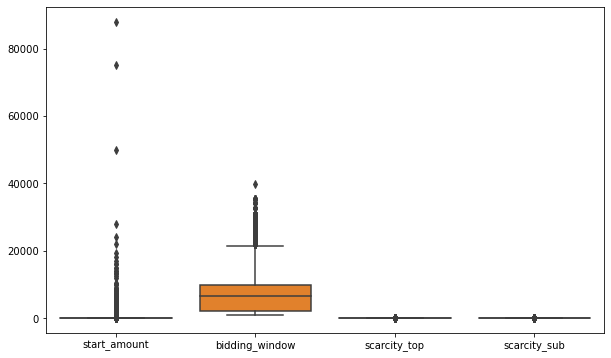

In [40]:
import seaborn as sns
from matplotlib import pyplot

# Boxplots before the outlier removal
fig, ax = pyplot.subplots(figsize=(10,6))

sns.boxplot(ax=ax, data=data[["start_amount","bidding_window", "scarcity_top", "scarcity_sub"]])

In [41]:
# Using isolation forest method to detect outliers

from sklearn.ensemble import IsolationForest

to_model_columns=["start_amount", "bidding_window"]

# Giving expected percentage of outliers as 0.5%
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.005), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

clf.fit(data[to_model_columns])
pred = clf.predict(data[to_model_columns])
data['anomaly']=pred

outliers=data.loc[data['anomaly']==-1]
outlier_index=list(outliers.index)

print("Outlier Indices")
print(outlier_index)

Outlier Indices
[214, 363, 465, 957, 1020, 1114, 1226, 1230, 1305, 1318, 1340, 1344, 1476, 1483, 1494, 1500, 1501, 1508, 1933, 1987, 2224, 2371, 3438, 4060, 4351, 4352, 4550, 4897, 5291, 6125, 6878, 7624, 8008, 8119, 8270, 8672, 9031, 9055, 9057, 9986, 10236, 10464, 10475, 10555, 10609, 10664, 10782, 10788, 10907, 11028, 11210, 11211, 11633, 11845, 11866, 12021, 12435, 12459, 12765, 13052, 13087, 13307, 13360, 13600, 13601, 13906, 13927, 14052, 14335, 14407, 14471, 14585, 14855, 15090, 15091, 15110, 15114, 15293, 15294, 15306, 15711, 15891, 16119, 16198, 16203, 16524, 16530, 16677, 16746, 16846, 16907, 17075, 17086, 17359, 17856, 18651, 18703, 18773, 18897, 19167, 19375, 19490, 19491, 19542, 19601, 19651, 19839, 19842, 19843, 19881, 19969, 19973, 20063, 20099, 20106, 20853, 21100, 21102, 21387, 22798, 22915, 23668, 23787, 24038, 24042, 24568, 24636, 25532, 25714, 25721, 25850, 26034, 26198, 26352, 26840, 27085, 27107, 27409, 27600, 28154, 28228, 28299, 28300, 28308, 28393, 28667, 28780

In [42]:
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(data['anomaly'].value_counts())

 1    66271
-1      327
Name: anomaly, dtype: int64


<AxesSubplot:>

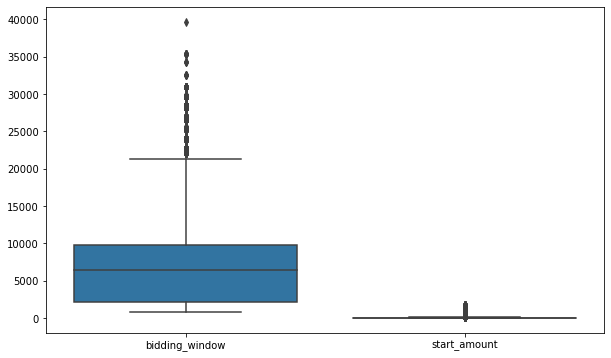

In [43]:
data = data[data["anomaly"] == 1]
data = data.drop(columns=["anomaly"])

# Boxplots after outlier removal
fig, ax = pyplot.subplots(figsize=(10,6))

sns.boxplot(ax=ax, data=data[["bidding_window","start_amount"]])

## Next Steps are Additional Steps for Prescriptive Analysis

### Adding End Price and Estimated Value for each lot (using the mean of the subcategories) 

In [44]:
sub_category_means

lot_subcategory
1-,2- en 4 -koloms hefbruggen           690.000000
380V aansluitmateriaal                   35.333333
3D Printers                             195.000000
Aan-/Opbouw                             258.333333
Aanstekers                               85.000000
                                           ...    
Zwembadonderhoud en -accessoires         26.333333
Zwembadpompen                            80.000000
Zwenk-/bokwielen                         23.062500
vervallen - bootonderdelen en divers     21.500000
videocamera                              75.419753
Name: bid_amount, Length: 1209, dtype: float64

In [45]:
# Adding estimated value
data = pd.merge(data, sub_category_means.to_frame(), on ='lot_subcategory', how ='left')
data = data.rename(columns={'bid_amount': 'expected_value'})
data.columns

KeyError: 'lot_subcategory'

In [34]:
# Adding end price
data = pd.merge(data, lot_values, on ='lot_id', how ='left')
data = data.rename(columns={'bid_amount': 'end_price'})
data.columns

Index(['auction_id', 'lot_id', 'valid_bid_count', 'auction_fee_tax_rate',
       'lot_topcategory', 'is_1euro_kavel', 'condition', 'seller_type',
       'is_sold', 'lot_subcategory', 'start_amount', 'increment_type',
       'final_closing_time', 'final_start_time', 'bidding_window', 'Day',
       'Month', 'is_homedelivery', 'is_public', 'is_automatic_credit',
       'sourcing_company', 'scarcity_top', 'scarcity_sub', 'expected_value',
       'end_price'],
      dtype='object')

In [35]:
# Adding SPEV feature for each lot
data["SPEV"] = data["start_amount"] / data["expected_value"]
data.columns

Index(['auction_id', 'lot_id', 'valid_bid_count', 'auction_fee_tax_rate',
       'lot_topcategory', 'is_1euro_kavel', 'condition', 'seller_type',
       'is_sold', 'lot_subcategory', 'start_amount', 'increment_type',
       'final_closing_time', 'final_start_time', 'bidding_window', 'Day',
       'Month', 'is_homedelivery', 'is_public', 'is_automatic_credit',
       'sourcing_company', 'scarcity_top', 'scarcity_sub', 'expected_value',
       'end_price', 'SPEV'],
      dtype='object')

In [36]:
# Adding LotsSale feature for each lot(it indicates how many items are there on the auction that this specific lot is in)

number_of_lots = data.groupby(["auction_id"]).size()

data = pd.merge(data, number_of_lots.to_frame(), on ='auction_id', how ='left')
data = data.rename(columns={0: 'LotsSale'})
data.columns

Index(['auction_id', 'lot_id', 'valid_bid_count', 'auction_fee_tax_rate',
       'lot_topcategory', 'is_1euro_kavel', 'condition', 'seller_type',
       'is_sold', 'lot_subcategory', 'start_amount', 'increment_type',
       'final_closing_time', 'final_start_time', 'bidding_window', 'Day',
       'Month', 'is_homedelivery', 'is_public', 'is_automatic_credit',
       'sourcing_company', 'scarcity_top', 'scarcity_sub', 'expected_value',
       'end_price', 'SPEV', 'LotsSale'],
      dtype='object')

In [37]:
# Adding relative position of each lot in its corresponding auction(sale)
data["LotNr"] = data.groupby("auction_id")["lot_id"].rank("dense", ascending=True)

# Checking if the ranks are correct
check = data.sort_values(by = ["auction_id", "lot_id"])
check

,auction_id,lot_id,valid_bid_count,auction_fee_tax_rate,lot_topcategory,is_1euro_kavel,condition,seller_type,is_sold,lot_subcategory,...,is_public,is_automatic_credit,sourcing_company,scarcity_top,scarcity_sub,expected_value,end_price,SPEV,LotsSale,LotNr
48838,37596,14108928,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,1.0,0.0,art,0.005814,0.009804,58.806508,NaN,2.040590,118,1.0
47312,37596,14108929,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,1.0,0.0,art,0.005814,0.009804,58.806508,NaN,2.465713,118,2.0
24731,37596,14108930,1.0,21,Horloges,0,Old,Seller,1,Horloge Heren,...,1.0,0.0,art,0.005814,0.009804,58.806508,155.0,2.465713,118,3.0
13337,37596,14108931,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,1.0,0.0,art,0.034483,0.062500,58.806508,NaN,0.765221,118,4.0
13097,37596,14108932,0.0,21,Horloges,0,Old,Seller,0,Horloge Heren,...,1.0,0.0,art,0.034483,0.062500,58.806508,NaN,0.680197,118,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17870,46216,14399963,0.0,21,Computers en Software,0,New,Seller,0,Laptops,...,0.0,0.0,bva,0.038462,0.200000,195.228731,NaN,0.015367,24,20.0
45554,46216,14399964,0.0,21,Computers en Software,0,New,Seller,0,Laptops,...,0.0,0.0,bva,0.012500,0.052632,195.228731,NaN,0.015367,24,21.0
25471,46216,14399965,0.0,21,Computers en Software,0,New,Seller,0,Laptops,...,0.0,0.0,bva,0.012500,0.052632,195.228731,NaN,0.015367,24,22.0
23140,46216,14399966,2.0,21,Computers en Software,0,Old,Seller,1,Laptops,...,0.0,0.0,bva,0.012500,0.052632,195.228731,25.0,0.102444,24,23.0


In [49]:
data.columns

Index(['auction_id', 'lot_id', 'auction_fee_tax_rate', 'is_1euro_kavel',
       'is_sold', 'start_amount', 'bidding_window', 'is_homedelivery',
       'is_public', 'is_automatic_credit', 'scarcity_top', 'scarcity_sub',
       'expected_value', 'end_price', 'SPEV', 'LotsSale', 'LotNr',
       'lot_topcategory_Accu-/ elektrisch gereedschap',
       'lot_topcategory_Auto-onderdelen en accessoires',
       'lot_topcategory_Computers en Software',
       'lot_topcategory_Dameskleding en -schoenen',
       'lot_topcategory_Herenkleding en -schoenen', 'lot_topcategory_Horloges',
       'lot_topcategory_Kantoorinrichting', 'lot_topcategory_Other',
       'lot_topcategory_Sanitair', 'lot_topcategory_Sieraden',
       'lot_topcategory_Slapen', 'lot_topcategory_Tuin en terras',
       'lot_topcategory_Unisex', 'lot_topcategory_Verlichting',
       'lot_topcategory_Woninginrichting', 'condition_New', 'condition_Old',
       'seller_type_New Seller', 'seller_type_Seller',
       'increment_type_nl 

In [51]:
# Exporting the csv file
data.to_csv("data_endprice.csv", index=False)